# Fairness, Accountability, Transparency and Ethics Course (FATE)

## Universitat Pompeu Fabra (UPF)
### Year 23/24
### Author: Manuel Portela (manuel.portela@upf.edu) with the contribution from Ioannis Bilionis (ibilionis@adherahealth.com)
*** Partially based on the original exercises made by David Solans (david.solans@upf.edu) ***
<br>
<br>
<br>
Submission date: 22/03/2024 at 23:59 on Aula Global

Please, implement this notebook **in pairs**.

<br>
<br>

**Legend** <br>
In this notebook we use:    
<div class="alert alert-block col-md-7 alert-info">To recall information from the theory classes and other tips</div>
<div class="alert alert-block col-md-7 alert-warning">To point important things that should not be 
   forgotten</div> 
<div class="alert alert-block col-md-7 alert-primary bg-primary">LAB TASK</div>

# 3. Part 2: Predicting with a COVID-19 Dataset

This project consist on applying the concepts and the techniques acquired during the course, with the addition of mitigation algorithms. 

The purpose of this project is to train a model that answer a specific question. Each group will have to choose a question and will have a subset of the original dataset to use. 

<div class="alert alert-block alert-info">We will work with subsets obtainef from the full dataset available at <a href="https://www.kaggle.com/datasets/omarlarasa/cov19-open-data-mexico">kaggle</a>.</div>

Use the question that correlates to your group with its corresponding dataset:
1. What is the probability of dying increase with the patient's age? 
2. What does probability change if the patient has another health issue? 
3. How dying probability increases when the patient has been intubated? 
4. Is it true that smoking increases the probability of dying by COV19?
5. Do pregnant women has more probability of being intubated?
6. How is the probability of hospitalization and probability of death are related to the length of symptoms?  
7. Is there a potential discrimination against Migrants? Hint: calculate the ratio between death and ICU/intubation


<div class="alert alert-block alert-success">
    <p><b>[To complete]</b></p>
    <p>Group number: 6</p>
    <p>Group members: Aitana Gonzalez, Berta Mitjavila </p>
    <p>Chosen question: How does the probability of dying from covid vary with the age of the patient?</p>
</div>

###  Libraries used in this notebook
You will need to install: **numpy**, **pandas**, **matplotlib**, and **sklearn**.

In [118]:
## Required statements
import pandas as pd
import numpy as np

from sklearn import linear_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score


from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult

from aif360.metrics import BinaryLabelDatasetMetric

from IPython.display import Markdown, display


from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore all warnings
import warnings
warnings.simplefilter("ignore")

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.1] Load and analyse your dataset (1 point)</h2>
    <hr>
     <p class="mb-0">Load your assigned dataset and answer the following questions:</p>

   <ol>
    <li>Is it k-anonymous?  [Interpret]</li>
    <li>Does it complies with l-diversity ? [interpret]</li>
    <li>Is it balanced? [Interpret]</li>
    <li>Select your protected class [justify]</li>
    <li>Define sensitive attributes [justify]</li>
   </ol>
</div>

In [74]:
df = pd.read_csv("../Data/deceased_dataset_v1.csv")
df.head()

,respiratory_hospital_unit,sex,admission_date,symptoms_onset_date,decease_date,intubation,pneumonia,age,native_speaker,native_mexican,...,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_renal_failure,smoker,ICU_admission,covid_positive,deceased_patient
0,1.0,1.0,12/10/2020,12/09/2020,12/14/2020,0.0,1.0,76.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,1.0,2.0,07/25/2020,07/18/2020,08/07/2020,0.0,0.0,55.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,1.0,1.0,05/19/2020,05/16/2020,05/23/2020,0.0,1.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1
3,0.0,2.0,01/19/2021,01/07/2021,01/25/2021,0.0,1.0,76.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,1.0,2.0,05/06/2020,05/02/2020,NaN,NaN,0.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0


In [75]:
df.columns.to_list()

['respiratory_hospital_unit',
 'sex',
 'admission_date',
 'symptoms_onset_date',
 'decease_date',
 'intubation',
 'pneumonia',
 'age',
 'native_speaker',
 'native_mexican',
 'diabetes',
 'epoc',
 'asma',
 'immunosuppression',
 'hypertension',
 'other_diseases',
 'cardiovascular',
 'obesity',
 'chronic_renal_failure',
 'smoker',
 'ICU_admission',
 'covid_positive',
 'deceased_patient']

In [76]:
# We will work only with covid_positive = 1 because we want the probability of dying due to covid
df = df[df['covid_positive'] == 1]

# As covid_positive is always 1, it is unuseful
# Attributes like 'admission_date' are not affected by the age so are irrelevant
df = df.drop(columns=['covid_positive', 'admission_date', 'symptoms_onset_date', 'decease_date'])

df.columns.to_list()

['respiratory_hospital_unit',
 'sex',
 'intubation',
 'pneumonia',
 'age',
 'native_speaker',
 'native_mexican',
 'diabetes',
 'epoc',
 'asma',
 'immunosuppression',
 'hypertension',
 'other_diseases',
 'cardiovascular',
 'obesity',
 'chronic_renal_failure',
 'smoker',
 'ICU_admission',
 'deceased_patient']

In [77]:
df.head()

,respiratory_hospital_unit,sex,intubation,pneumonia,age,native_speaker,native_mexican,diabetes,epoc,asma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_renal_failure,smoker,ICU_admission,deceased_patient
0,1.0,1.0,0.0,1.0,76.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.0,2.0,0.0,0.0,55.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,1.0,0.0,1.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
3,0.0,2.0,0.0,1.0,76.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,1.0,2.0,0.0,1.0,38.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### K-anonimity

**Identifiers:** These are unique attributes that can be used to identify an individual. In this dataset, there doesn’t seem to be any explicit identifiers like name, social security number, or patient ID.

**Quasi-identifiers:** These are attributes that, in combination, can be used to identify an individual. In this dataset, the following could be considered quasi-identifiers: ‘age’, 'pneumonia'.

**Confidential attributes:** These are sensitive attributes that should be protected. In this dataset, the following could be considered confidential attributes: 'sex', 'native_speaker’, ‘native_mexican’.

**Other:** These attributes could also be considered sensitive attributes, however, as far as our study is concerned, they are attributes that are related to a person's state of health, as well as possible habits (such as smoking). These attributes are related to a person's age, so we consider them as "other": ‘respiratory_hospital_unit’, ‘intubation’, ‘diabetes’, ‘epoc’, ‘asma’, ‘immunosuppression’, ‘hypertension’, ‘other_diseases’, ‘cardiovascular’, ‘obesity’, ‘chronic_renal_failure’, ‘smoker’, ‘ICU_admission’, ‘deceased_patient’.

In [78]:
## Use a helper function that calculates the groups by value
## If using pandas, you can consider using grouping and group sizes for that
def get_values_frequencies(_df, quasi_identifier_cols):
    _df = _df.groupby(quasi_identifier_cols).size().reset_index(name='Count')
    return _df[_df['Count'] != 0]

## Code a function that uses the function above and determines whether a given dataset satifies K-anonimity 
# for a given K
def is_k_anonymous(_df, K, quasi_identifier_cols):
    value_counts = get_values_frequencies(_df, quasi_identifier_cols)
    max_k = min(value_counts['Count'])
    if K < max_k:
        return str(all(value_counts['Count'] >= K)) + f', and it is {max_k}-anonymous too.'
    else:
        return all(value_counts['Count'] >= K)

In [79]:
print("Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)?", is_k_anonymous(df, 2, ['age', 'pneumonia']))


Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)? True, and it is 4-anonymous too.


As we can observe, with the given quasi-identifiers, the dataset is not 2-anonymous. If a dataset does not satisfy 2-anonymity, it means that there are individuals in the dataset who can be uniquely identified based on the quasi-identifiers.

In [80]:
df.groupby(by=['age', 'pneumonia']).size()

age   pneumonia
12.0  0.0           38
      1.0            6
13.0  0.0           51
      1.0            6
14.0  0.0           47
                  ... 
88.0  1.0          363
89.0  0.0          140
      1.0          311
90.0  0.0          111
      1.0          250
Length: 158, dtype: int64

The previous output shows the count of records for each unique combination of the four quasi-identifiers, and we can observe that there is an individual that can be uniquely identified.

In [81]:
df[(df['age'] == 14.0) & (df['pneumonia'] == 1.0)]

,respiratory_hospital_unit,sex,intubation,pneumonia,age,native_speaker,native_mexican,diabetes,epoc,asma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_renal_failure,smoker,ICU_admission,deceased_patient
34793,0.0,2.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
55140,1.0,2.0,NaN,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
87519,0.0,1.0,1.0,1.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
199231,0.0,2.0,1.0,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1


Given this situation, we will have to **anonymize** the dataset. In this case, we could apply generalization to the ‘age’ attribute.

In [82]:
unique_ages = df['age'].unique()
unique_ages.sort()
print(unique_ages)

[12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.
 84. 85. 86. 87. 88. 89. 90. nan]


In [83]:
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
df = df.drop(columns=['age'])
df.head()

,respiratory_hospital_unit,sex,intubation,pneumonia,native_speaker,native_mexican,diabetes,epoc,asma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_renal_failure,smoker,ICU_admission,deceased_patient,age_group
0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,70-80
1,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,50-60
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,80-90
3,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,70-80
10,1.0,2.0,0.0,1.0,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30-40


We check that there is no individual who can be uniquely identified.

In [84]:
get_values_frequencies(df, ['age_group', 'pneumonia'])

,age_group,pneumonia,Count
0,10-20,0.0,600
1,10-20,1.0,91
2,20-30,0.0,3648
3,20-30,1.0,893
4,30-40,0.0,6053
5,30-40,1.0,2948
6,40-50,0.0,6912
7,40-50,1.0,7361
8,50-60,0.0,7867
9,50-60,1.0,13117


In [85]:
print("Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)?", is_k_anonymous(df, 2, ['age_group', 'pneumonia']))


Given the previously established quasi-identifiers, does the dataset satisfy 2-anonymity)? True, and it is 91-anonymous too.


### L-diversity

In [86]:
def is_l_diverse(df, partitions, sensitive_column, l=2):
    #your function here
    
    aux = True
    
    # Step 1: Create Qi groups
    qi_groups = df.groupby(partitions)
    
    # Step 2: Check ℓ-diversity for each Qi group
    for group_name, group_data in qi_groups:
        unique_sensitive_values = group_data[sensitive_column].nunique()
        
        # Check if the number of unique sensitive attribute values is more than ℓ
        if unique_sensitive_values > l:
            print(f'{group_name} -> false')  # Print combination + False
            aux = False  # Dataset does not satisfy ℓ-diversity for this group
    
    # Step 3: All Qi groups satisfy ℓ-diversity
    return f"* l-diversity of the dataset: {aux}"

In [87]:
# Defining groups and sensitive column
target_columns = ["age_group", "pneumonia"]
sensitive_column = "sex"

for i in range(2,6):
    print('For l =', i, ': ')
    print(is_l_diverse(df, target_columns, sensitive_column, l=i), "\n")

For l = 2 : 
* l-diversity of the dataset: True 

For l = 3 : 
* l-diversity of the dataset: True 

For l = 4 : 
* l-diversity of the dataset: True 

For l = 5 : 
* l-diversity of the dataset: True 



<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.2] Prepare your dataset and train a model (0.5 point)</h2>
    <hr>
    <p class="mb-0">Split your dataset for train and test [Code]</p>
     <p>Then, train a classifier (scikit-learn model) [Code] considering the question that you should solve [justify]. </p>
</div>



In [91]:
# encoded the age group column
age_col = df['age_group']
encoder = LabelEncoder()
df['age_group_encoded'] = encoder.fit_transform(age_col)

In [103]:
## Your code here
# split the data
X = df.drop(['deceased_patient', 'age_group'], axis=1)  # Features
y = df['deceased_patient']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
# Handling missing values in the features using SimpleImputer - REVIEW
# hi ha valors null i al logistic regression no li podem posar nulls - revisar que femb amb els nuls. 
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

In [116]:
# train the classifier

# logistic regression ? - review which classifier
model_name = LogisticRegression()
model_name.fit(X_train, y_train)

# Predicting on the testing set
y_pred = model_name.predict(X_test)

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.3] Assess your model performance (1 point)</h2>
    <hr>
    <p class="mb-0">You should analyse the following analysis:</p>
    <ol>
        <li>Performance metrics [interpret]</li>
        <li>Use Specificity to understand how well it classifies TRUE NEGATIVES (important for COVID) [Interpret</li>
        <li>Training a XGB regressor analyse the risk factors used in this dataset and how they impact on your protected class.  [Code and Interpret]</li>
    </ol>
     
</div>

<div class="alert alert-block alert-info col-md-12">
    <p><b>Specificity metric:</b> (true negative rate) is the probability of a negative test result, conditioned on the individual truly being negative. This is important on COVID-19 detection because we know that is hard to detect the infection, therefore there has been many false negatives, resulting in underidentification.</p>
    <p><b>Analysing factors:</b> When using multiple attributes for a classifier, each attribute can have a different impact in the precision of the algorithm, which also varies regarding the dataset. Understanding the weights of each factor can help to understand what are the effects on the protected class.</p>
</div>

Model Performance Analysis - LogisticRegression():
Accuracy: 0.8791
ROC AUC: 0.8018
Precision: 0.901
Recall: 0.9465

Classification report - summary:
              precision    recall  f1-score   support

           0       0.79      0.66      0.72      4842
           1       0.90      0.95      0.92     15967

    accuracy                           0.88     20809
   macro avg       0.84      0.80      0.82     20809
weighted avg       0.87      0.88      0.88     20809



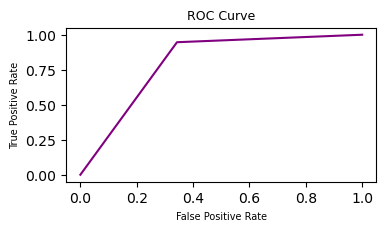

In [122]:
## Your code here
# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

 # Display results
print(f'Model Performance Analysis - {model_name}')
print('Accuracy:', round(accuracy, 4))
print('ROC AUC:', round(roc_auc, 4))
print('Precision:', round(precision, 4))
print('Recall:', round(recall, 4))

# classification report
print('\nClassification report - summary:')
print(classification_report(y_test, y_pred, zero_division='warn'))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=model_name.classes_[1])
plt.figure(figsize=(4, 2)) 
plt.plot(fpr, tpr, color='purple')
plt.title('ROC Curve', size = 9)
plt.xlabel('False Positive Rate', size = 7)
plt.ylabel('True Positive Rate', size = 7)
plt.show()

Model Error Analysis - LogisticRegression()
False Positive Rate: 0.3428
False Negative Rate: 0.0535


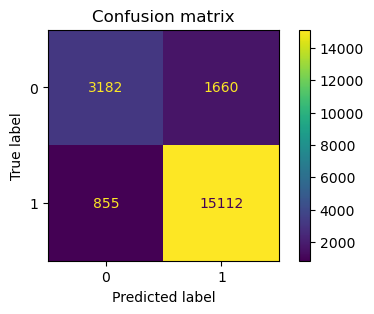

In [124]:
# confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred)

# compute FPR and FNP - errors
fpr = conf_matrix[0][1]/conf_matrix[0].sum()
fnp = conf_matrix[1][0]/conf_matrix[1].sum()

print(f"Model Error Analysis - {model_name}")
print('False Positive Rate:', round(fpr, 4))
print('False Negative Rate:', round(fnp, 4))

# Plot confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
fig, ax = plt.subplots(figsize=(5, 3))
disp.plot(ax=ax)

plt.title('Confusion matrix')
plt.show()

In [127]:
# compute specificity
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("Specificity:", round(specificity, 4))

Specificity: 0.6572


In [128]:
#preparing the data by changing the dtype of columns
s = X_train.select_dtypes(include='object').columns
X_train[s] = X_train[s].astype("float")

#training an XGBoost classifier
barWidth = 0.9
model = XGBClassifier(objective="binary:logistic")
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

#plot
plt.figure(4, figsize=(12, 6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#FF796C', width=barWidth,
        edgecolor='black')
plt.title('Risk Factors with XGB Regressor', size=20)
plt.xticks(rotation='vertical', fontsize=6)
plt.yticks(fontsize=14)
plt.ylabel('Coefficient of Importance', fontsize=14)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

**1.Performance metrics.**


**2.Use Specificity to understand how well it classifies TRUE NEGATIVES.**

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.4] Assess the fairness metrics (1 point)</h2>
    <hr>
    <p class="mb-0">Assess the performance from the fairness point of view of the created model.</p>
    <p>For that, you should plot the result of some fairness metric for classification.</p>
    <p> You can just use the same metrics we used in Part 1, but remember to add other metrics if you need them to detect changes of performance in the following exercises.</p>
</div>

In [ ]:
## Your code here

### Unfairness mitigation algorithms  in AIF360
The library contains a set of algorithms to mitigate potential unfairness in machine-learning pipelines.

The provided algorithms correspond implementation of to state of the art techniques (most of them contain a link to a scientific paper that introduced them).

The existing algorithms can be found [here](https://aif360.readthedocs.io/en/latest/modules/algorithms.html).

They are divided between:
- **Preprocessing.** Algorithms that are applied before starting the learning process (modification of the input data before feeding it to the model).

- **Inprocessing.** Algorithms that are applied during the learning process (e.g.: modification of the loss function to account for fairness).

- **Postprocessing.** Algorithms that are applied after the predictions of the models, substituting them for more fair solutions.

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.5] Apply mitigation algorithms to your model (0.5 points)</h2>
    <hr>
     <p class="mb-0">Apply an unfairness mitigation algorithm of your election, train a new classifier of the same family used above and assess the new performance from the fairness point of view.</p>
    <p>Provide a textial description of the results (max 3 lines).</p>
</div>



<div class="alert alert-block alert-info col-md-12">

<p>Although you can try other algorihtms if you want, the suggested algorithms to mitigate unfairness are the following:</p>

    
<ul>
<li><b><a href="https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.preprocessing.DisparateImpactRemover.html" >Preprocessing</a></b>
<ul>
<li>Disparate Impact Remover</li>
<li>Rewighing (you need a classifier that allows you to parametrize sample weights for this)</li>
</ul>

</li>
<li><b><a href="https://aif360.readthedocs.io/en/latest/modules/algorithms.html#aif360-algorithms-inprocessing">Inprocessing</a></b>
<ul>
<li>MetaFairClassifier</li>
</ul>
</li>
<li><b><a href="https://aif360.readthedocs.io/en/latest/modules/algorithms.html#module-aif360.algorithms.postprocessing">Postprocessing</a></b>
<ul>
<li>Disparate Impact Remover</li>
<li>EqOddsPostprocessing (You need to use the equalized odds ratio to measure performance of this classifier and the classifier trained above)</li>
</ul>
</li>
</ul>

<p>You can add necessary imports for using the algorithm</p>

</div>


<div class="alert alert-block alert-warning col-md-12">
    <p>Sometimes, certain algorithms do not work well with certain classifiers / output distributions</p>
    <p>This can happen for several reasons, one of them being the changes done for subsequent versions of the tool</p>
    <br>
    <p><b>If you see that your unfairness mitigation algorithm does not work as expected, do not invest too much time trying to solve it, use another algorithm.</b></p>
</div>   

In [ ]:
## Your code here

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.6] Assess the effects of the mitigation technique (1 point)</h2>
    <hr>
     <p class="mb-0">Analyse the performance of the effects of the mitigation algorithm in the performance of your model. You can iterate over your training to get the best result (in relation to you goal). Explain how do arrive to the best choice and why it is the best one.</p>
</div>


In [ ]:
## Your code here

<div class="alert alert-block alert-primary bg-primary head-2">
    <h2 class="alert-heading">[L3.7] Executive report (5 points)</h2>
    <hr>
     <p class="mb-0">After analysing your dataset and training your models, please create a 1-3 page report containing the following items (on your consideration): </p>
    <ul>
        <li>Anonymization of the dataset</li>
        <li>Fairness in original dataset</li>
        <li>Factors that impact on discrimination</li>
        <li>Fairness metrics</li>
        <li>Algorithms used for training the model</li>
        <li>Algorithmic performance expected and obtained</li>
        <li>Algorithmic metrics applied</li>
        <li>Algorithmic performance after the metrics</li>
        <li>Conclusions regarding the goal of your model and the expected utility in a real-case scenario</li>
    </ul>
</div>

<div class="alert alert-block alert-warning">
<p>You can include figure if you consider necessary, and you can reuse observations from the notebook, please avoid placing code in the report.</p>
<p>Please, include the contribution of each of the team mates to this project. </p>
</div> 
